In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import root_mean_squared_error
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv')
df.head()

,JAMB_Score,Study_Hours_Per_Week,Attendance_Rate,Teacher_Quality,Distance_To_School,School_Type,School_Location,Extra_Tutorials,Access_To_Learning_Materials,Parent_Involvement,IT_Knowledge,Student_ID,Age,Gender,Socioeconomic_Status,Parent_Education_Level,Assignments_Completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,4,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,5,22,Female,Medium,Tertiary,1


### Data Preparation

In [3]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [4]:
del df['student_id']
df.fillna(0, inplace=True)
df.head()

,jamb_score,study_hours_per_week,attendance_rate,teacher_quality,distance_to_school,school_type,school_location,extra_tutorials,access_to_learning_materials,parent_involvement,it_knowledge,age,gender,socioeconomic_status,parent_education_level,assignments_completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,15,Male,High,0,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,22,Female,Medium,Tertiary,1


In [5]:
# Splitting data
def train_test_val(df, y, test=0.2, val=0.2, random_state=1):
    df_full_train, df_test = train_test_split(df, test_size=test, random_state=random_state)
    df_train, df_val = train_test_split(df_full_train, test_size= val/(1-test) , random_state=random_state)
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    y_train = df_train[y].values
    y_val = df_val[y].values
    y_test = df_test[y].values
    del df_train[y]
    del df_val[y]
    del df_test[y]
    return df_train, df_val, df_test, y_train, y_val, y_test

In [6]:
df_train, df_val, df_test, y_train, y_val, y_test = train_test_val(df, 'jamb_score')
# One-hot encoding of variables
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

### Question 1

In [7]:
dt = DecisionTreeClassifier(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=1)

In [8]:
y_pred = dt.predict(X_val)
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- study_hours_per_week <= 18.50
|   |--- class: 118
|--- study_hours_per_week >  18.50
|   |--- class: 190



### Question 2

In [9]:
rf = RandomForestClassifier(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=1)

In [10]:
y_pred = rf.predict(X_val)
root_mean_squared_error(y_val, y_pred)

65.51460142594168

### Question 3

In [22]:
n_estimators = np.arange(10, 201, 10)
scores = []
for n in n_estimators:
    rf = RandomForestClassifier(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    scores.append(round(root_mean_squared_error(y_val, y_pred), 3))
scores

[65.515,
 59.102,
 58.222,
 57.336,
 56.74,
 55.923,
 55.158,
 54.671,
 55.321,
 55.105,
 55.747,
 55.756,
 54.845,
 54.849,
 54.664,
 54.343,
 54.478,
 54.558,
 54.964,
 55.136]

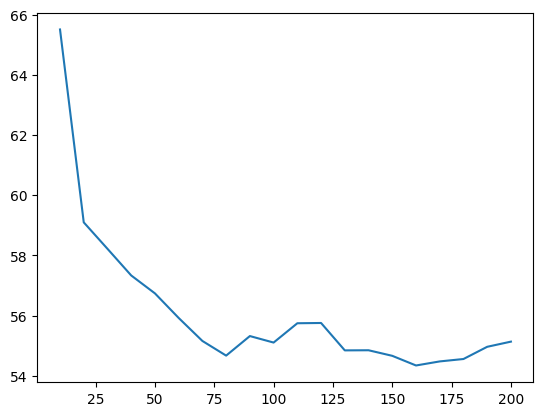

In [24]:
plt.plot(n_estimators, scores)

### Question 4

In [32]:
max_depth = [10, 15, 20, 25]
n_estimators = np.arange(10, 201, 10)
scores = []
for m in max_depth:
    for n in n_estimators:
        rf = RandomForestClassifier(n_estimators=n, max_depth=m, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        scores.append((m, n, round(root_mean_squared_error(y_val, y_pred), 3)))

In [33]:
columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.groupby('max_depth').mean()

,n_estimators,rmse
max_depth,,
10,105.0,53.64780
15,105.0,54.32300
20,105.0,56.53840
25,105.0,56.52045


### Question 5

In [34]:
rf = RandomForestClassifier(n_estimators=10, max_depth=20,random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [46]:
data = list(zip(df_train.columns, rf.feature_importances_))
new_df = pd.DataFrame(data, columns =['Feature', 'Importance'])

In [53]:
new_df

,Feature,Importance
0,study_hours_per_week,0.020155
1,attendance_rate,0.023425
2,teacher_quality,0.084565
3,distance_to_school,0.043678
4,school_type,0.106952
5,school_location,0.115719
6,extra_tutorials,0.022349
7,access_to_learning_materials,0.022891
8,parent_involvement,0.023322
9,it_knowledge,0.024089


### Question 6